In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

data_folder = 'C:/Users/lgspa/Downloads'

sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

In [2]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

In [3]:
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

In [4]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

In [5]:
import yfinance as yf

stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

# Remove 'ATVI' from the list if it exists
if 'ATVI' in stocks_list:
    stocks_list.remove('ATVI')
    print("'ATVI' symbol excluded from further processing.")

successful_symbols = []

for symbol in stocks_list:
    try:

        prices_df_temp = yf.download(tickers=symbol,
                                     start='2021-01-01',
                                     end='2023-03-01')
        
        successful_symbols.append(symbol)
        print(f"Data for '{symbol}' downloaded successfully.")
        
    except Exception as e:

        print(f"Failed to download data for '{symbol}': {e}")

prices_df = yf.download(tickers=successful_symbols,
                        start='2021-01-01',
                        end='2023-03-01')


'ATVI' symbol excluded from further processing.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data for 'AAPL' downloaded successfully.
Data for 'AMD' downloaded successfully.



[*********************100%%**********************]  1 of 1 completed


Data for 'AMZN' downloaded successfully.
Data for 'BA' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'CRM' downloaded successfully.
Data for 'ES' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'F' downloaded successfully.
Data for 'GOOG' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'GOOGL' downloaded successfully.
Data for 'JPM' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'META' downloaded successfully.
Data for 'MNST' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data for 'MSFT' downloaded successfully.
Data for 'NFLX' downloaded successfully.



[*********************100%%**********************]  1 of 1 completed


Data for 'NKE' downloaded successfully.
Data for 'NVDA' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data for 'PFE' downloaded successfully.
Data for 'TSLA' downloaded successfully.



[*********************100%%**********************]  1 of 1 completed

Data for 'ABBV' downloaded successfully.
Data for 'ABT' downloaded successfully.



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'C' downloaded successfully.
Data for 'CMG' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'DIS' downloaded successfully.
Data for 'EA' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'EBAY' downloaded successfully.
Data for 'FCX' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'GS' downloaded successfully.
Data for 'K' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data for 'KEY' downloaded successfully.



[*********************100%%**********************]  1 of 1 completed


Data for 'KO' downloaded successfully.
Data for 'MA' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'MO' downloaded successfully.
Data for 'MU' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'PEP' downloaded successfully.
Data for 'STZ' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'T' downloaded successfully.
Data for 'TSN' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'V' downloaded successfully.
Data for 'PG' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'OXY' downloaded successfully.
Data for 'AAL' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'DAL' downloaded successfully.
Data for 'EL' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'GILD' downloaded successfully.
Data for 'J' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'LUV' downloaded successfully.
Data for 'PM' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'SLB' downloaded successfully.
Data for 'AES' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'REGN' downloaded successfully.
Data for 'A' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'D' downloaded successfully.
Data for 'ILMN' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'L' downloaded successfully.
Data for 'CB' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'HBAN' downloaded successfully.
Data for 'BIIB' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'MRO' downloaded successfully.
Data for 'NUE' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'BKR' downloaded successfully.
Data for 'DD' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed


Data for 'TMO' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'AEP' downloaded successfully.
Data for 'ENPH' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'AAP' downloaded successfully.
Data for 'MRNA' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'INTC' downloaded successfully.
Data for 'LMT' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data for 'NCLH' downloaded successfully.



[*********************100%%**********************]  1 of 1 completed


Data for 'JNJ' downloaded successfully.
Data for 'PYPL' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'BMY' downloaded successfully.
Data for 'CVX' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'HON' downloaded successfully.
Data for 'XOM' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'DVN' downloaded successfully.
Data for 'MPC' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'RCL' downloaded successfully.
Data for 'AVGO' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'DG' downloaded successfully.
Data for 'DLTR' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for 'MDT' downloaded successfully.
Data for 'CCL' downloaded successfully.


[*********************100%%**********************]  1 of 1 completed
[***                    6%%                      ]  5 of 84 completed

Data for 'ALB' downloaded successfully.


[*********************100%%**********************]  84 of 84 completed


In [6]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date]
    
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


In [7]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


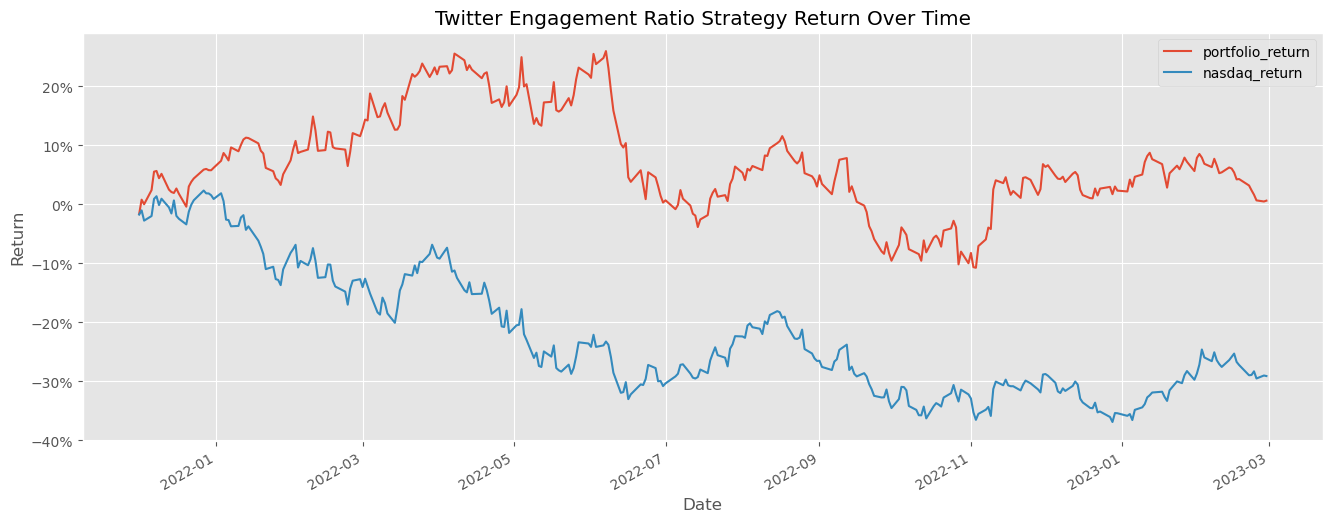

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick  

portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')
plt.show()
